In [1]:
import sys
import glob
import re
import fnmatch
from os import listdir
from os.path import join, isfile, basename

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

import pandas 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# VFB labels and label names
labels = [16,64,8,32,2,4,65,66,33,67,34,17,69,70,35,71,9,18,72,36,73,74,37,75,19,76,38,77,39,78,79,20,5,40,80,10,81,82,83,84,85,86,11,22,23,24,12,3,6,49,50,25,51,13,52,26,53,27,54,55,56,28,7,14,57,58,29,59,30,60,15,61,31,62,63]
label_names_file = '/groups/saalfeld/home/bogovicj/vfb/DrosAdultBRAINdomains/refData/Original_Index.tsv'

label_names = pandas.read_csv( label_names_file, delimiter='\t', header=0 )
# print label_names[ label_names['Stack id'] == 11 ]['JFRCtempate2010.mask130819' ].iloc[0]
# print label_names[ label_names['Stack id'] == 70 ]['JFRCtempate2010.mask130819' ].iloc[0]

def get_label_name( label_id ):
    return label_names[ label_names['Stack id'] == label_id ]['JFRCtempate2010.mask130819' ].iloc[0]

# label_names['JFRCtempate2010.mask130819']
# label_names

In [3]:
ids = np.unique( label_names.as_matrix( columns=['Stack id']))
print ids

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86]


In [4]:
# Relevant directories

neuron_list_file="/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/prefix_list_by_neuron.txt"
f=open(neuron_list_file)
tmp=f.read().splitlines()
f.close()
neurons = [ n.split(' ') for n in tmp ]

print ' '
name1 = 'ants_jfrc2'
jfrcDir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp'
print jfrcDir

name2 = 'ants-el-ag_owl'
grpDir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp'
print grpDir

names = [ name1, name2 ]
print names 

 
/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp
/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp
['ants_jfrc2', 'ants-el-ag_owl']


In [10]:
jfrc_hist_sizes = pandas.read_csv( '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp/totals.csv', header=None, names=['pair','count'] )
grp_hist_sizes = pandas.read_csv( '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp/totals.csv', header=None, names=['pair','count'] )


In [293]:
np.unique( jfrc_hist_sizes.as_matrix( columns=['label']))


array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85, 86])

In [11]:
# Functions

def flatten( list_of_lists ):
    return [ item for sublist in list_of_lists for item in sublist ]

def getCount( df_counts, pair_name ):
    res = df_counts[ df_counts.pair == pair_name ]['count']

def normalizeHistogram( hist ):
    hist[:,1] = hist[:,1]/np.sum( hist[:,1])
    return hist

def plotHistBar( hist, title ):
    x = hist[1:-1,0]
    y = hist[1:-1,1]
    plt.bar( x, y )
    plt.xlabel('Distance')
    plt.ylabel('Freq')
    plt.title( title )
    
def plotHistsTogether( hists, names ):
    for i in range( len( hists )):
        hist = hists[ i ]
        x = hist[1:-1,0]
        y = hist[1:-1,1]
        plt.plot( x, y )

    plt.xlabel('Distance')
    plt.ylabel('Freq')
    plt.legend( names )
    
def findHistCsv( folder, label, line ):
    testf = join( folder, 'combined__labelHist_{}_line{}.csv'.format( label, line ))
    if isfile( testf ):
        return testf
    else:
        print'could not find file for label {} and line {} in folder {}'.format( label, line, folder )
        return None
    
def findHistStatCsv( line_names, folder, label, line ):
    out = []
    for prefix in line_names[ line ]:
        pattern = '{}/{}*_labelHist_stats_{}.csv'.format(folder,prefix,label)
#         print pattern
        possibles = glob.glob( pattern )
        #print 'possibles ', possibles
        out += possibles
    return out

def concatenateCentiles( centile_files, cent=0.5 ):
    out = np.array([[]])
    for f in centile_files:
        try:
            stats = genfromtxt( f, delimiter=',' )
            a = stats[1, np.argwhere(stats[0,:]==cent )]
            out = np.concatenate( (out,a), axis=1)
        except ValueError:
            continue
    return out

def getHistogramCounts( centile_files ):
    out = np.array([[]])

def cheap_hist_percentile( hist_in, percentile ):
    hist = hist_in[1:-1,:]
    total=np.sum(hist[:,1])
    cumsum=np.cumsum(hist[:,1])
    return hist[ cumsum > ( percentile * total ), 0 ][ 0 ]

def counts( df_pair_label_counts, names ):
    results = []
    for n in names: 
        pair=basename( n.replace('_stats_','_'))
#         print pair
        thiscount = df_pair_label_counts[ df_pair_label_counts[ 'pair' ] == pair ]['count']

        if thiscount.size != 1:
            continue

        results += [ thiscount.values ]
#         print results
        
    return np.mean( np.array( results ))

#findHistStatCsv( neurons, jfrcDir, 25, 1 )
#findHistCsv( jfrcDir, 26, 0)

# for l in labels:

#     jfrcHistStatFileList = findHistStatCsv( neurons, jfrcDir, l, line )
#     grpHistStatFileList  = findHistStatCsv( neurons, grpDir, l, line )
# #     print grpHistStatFileList
# #     print ' '
#     print counts( jfrc_hist_sizes, grpHistStatFileList )
# #     break
    
# pair = '20170223_32_A2-20170223_32_A6_SAME_labelHist_16.csv'
# thiscount = jfrc_hist_sizes[ jfrc_hist_sizes[ 'pair' ] == pair ]['count']
# # np.mean(thiscount.values)
# thiscount.size

In [25]:
# Preprocess 
line = 1
sample_counts = []
for l in labels:
    jfrcHistStatFileList = findHistStatCsv( neurons, jfrcDir, l, line )
    grpHistStatFileList  = findHistStatCsv( neurons, grpDir, l, line )
    
    nj = counts( jfrc_hist_sizes, jfrcHistStatFileList )
    ng = counts( grp_hist_sizes, grpHistStatFileList )
    sample_counts += [ ( nj + ng)  ]

sample_counts = np.array( sample_counts )
sample_counts[ np.isnan( sample_counts ) ] = 0 

print sample_counts

sort_idxs = ( np.argsort( sample_counts ) )[::-1] # Reverse so its in descending order
# print sort_idxs

sorted_counts = np.array( sample_counts )[ sort_idxs  ]
labels_sorted_by_n_samples = np.array( labels )[ sort_idxs ]

# print sorted_counts
# print labels_sorted_by_n_samples

labels_of_interest = labels_sorted_by_n_samples[ sorted_counts > 0 ]
print labels_of_interest

# print sorted_counts[ 0 ]
# sorted_counts[ sorted_counts > 0 ]

print ' '
xlabels = flatten( [ [ str(get_label_name(l)), ''] for l in labels_sorted_by_n_samples ] )
print xlabels

[  1.33333333e+02   1.15366667e+03   1.37333333e+02   3.21000000e+02
   1.51333333e+02   1.93333333e+01   5.37333333e+02   4.09333333e+02
   2.14400000e+04   3.68000000e+02   4.14333333e+02   1.37600000e+03
   3.58766667e+03   0.00000000e+00   3.52100000e+03   1.38616667e+04
   5.14566667e+03   1.48733333e+03   3.44773333e+04   1.02710000e+04
   7.33666667e+02   5.66166667e+03   3.95100000e+03   1.55703333e+04
   9.27000000e+02   3.19733333e+03   5.29333333e+02   4.00000000e+02
   1.98503333e+04   1.95840000e+04   4.35666667e+02   0.00000000e+00
   1.06666667e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.01050000e+04   4.06866667e+03   2.67666667e+02   1.99310000e+04
   1.04000000e+02   3.33333333e-01   1.80533333e+03   2.12533333e+03
   8.66666667e+00   3.27000000e+02   1.63133333e+04   7.45766667e+03
   2.59866667e+03   8.08200000e+03   0.00000000e+00   1.34570000e+04
   3.00000000e+00   2.15000000e+02   1.34333333e+02   3.38333333e+02
   8.45633333e+03   3.07836667e+04

(116, 6)


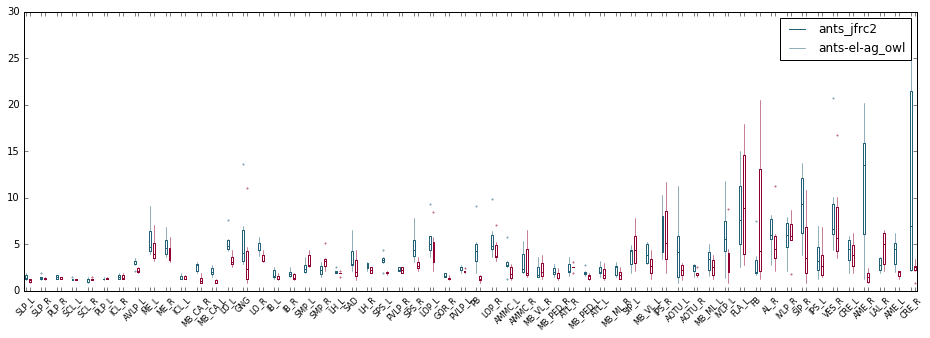

In [26]:
# Do histograms
# Go on a perline

line = 1
data = None

xpositions = []
space = 2
p = 1

sample_counts = []

for l in labels_of_interest:
#     print ' '
#     print 'label ', l
    
    jfrcHistStatFileList = findHistStatCsv( neurons, jfrcDir, l, line )
    grpHistStatFileList  = findHistStatCsv( neurons, grpDir, l, line )

    resJfrc = concatenateCentiles( jfrcHistStatFileList )
    resGrp = concatenateCentiles( grpHistStatFileList )
#     print resJfrc.shape
#     print resGrp.shape
    
    if( resJfrc.shape[1] != resGrp.shape[1] ):
#         print 'skipping'
        sample_counts += [ 0 ]
#         print len(sample_counts)
        continue

    if( np.any( np.array(resJfrc.shape) == 0 ) ):
#         print 'skipping'
        sample_counts += [ 0 ]
#         print len(sample_counts)
        continue

    if( np.any( np.array(resGrp.shape) == 0 )):
#         print 'skipping'
        sample_counts += [ 0 ]
#         print len(sample_counts)
        continue
        
    if data is not None:
        
        if( resJfrc.shape[1] != data.shape[1] ):
            sample_counts += [ 0 ]
#             print len(sample_counts)
#             print 'skipping'
            continue
            
        if( resGrp.shape[1] != data.shape[1] ):
            sample_counts += [ 0 ]
#             print len(sample_counts)
#             print 'skipping'
            continue
            
        data = np.concatenate( (data,resJfrc,resGrp), axis=0 )
    else:
        data = np.concatenate( (resJfrc,resGrp), axis=0 )

    nj = counts( jfrc_hist_sizes, jfrcHistStatFileList )
    ng = counts( grp_hist_sizes, grpHistStatFileList )
    sample_counts += [ ( nj + ng)  ]
#     print len( sample_counts )

    xpositions += [ p, p+1 ]
    p += ( 2 + space )

# END OF LOOP

print data.shape
# print xpositions
bp = plt.boxplot( np.transpose( data ), positions=xpositions) # suppress output

fig = plt.gcf()
fig.set_size_inches( 16, 5 )

c1 = '#226078'
c2 = '#910033'
even = True
for box in bp['boxes']:
    if even:
        box.set( color=c1, linewidth=1)
    else:
        box.set( color=c2, linewidth=1)
    even = not even

i = 0
for w in bp['whiskers']:
    if i == 0 or i == 1:
        w.set( color=c1, linewidth=0.5, linestyle='-')
    else:
        w.set( color=c2, linewidth=0.5, linestyle='-')
    i += 1
    
    if i == 4: 
        i = 0
    
even = True
for m in bp['medians']:
    if even:
        m.set( color=c1, linewidth=1)
    else:
        m.set( color=c2, linewidth=1)
    even = not even

for c in bp['caps']:
    c.set_visible( False )
    
even = True
for flier in bp['fliers']:
    if even:
        flier.set(marker='.', markeredgecolor=c1, markerfacecolor=c1, markersize=3, alpha=0.5 )
    else:
        flier.set(marker='.', markeredgecolor=c2, markerfacecolor=c2, markersize=3, alpha=0.5 )
    even = not even
    
# Plot sample counts
ax = plt.gca()
# maxy = ax.get_ylim()
# plt.plot( xpositions, sorted_counts / ( maxy / sorted_counts[ 0 ]))

plt.legend( names )

ax.set_xticklabels( xlabels )
plt.setp( ax.get_xticklabels(), rotation=45, fontsize=8 )

plt.savefig('/nrs/saalfeld/john/projects/flyChemStainAtlas/comparisons/test.svg')

In [ ]:
# Testing stuff out

# print xpositions
# y = 30. - ( 30. / 230. ) * np.array( xpositions )
# print y
# plt.boxplot( np.transpose( data ), positions=xpositions) # suppress output
# plt.plot( y )

# plt.gca().get_ylim()
# print labels_of_interest

# l = 49
# jfrcHistStatFileList = findHistStatCsv( neurons, jfrcDir, l, line )
# grpHistStatFileList  = findHistStatCsv( neurons, grpDir, l, line )

# print concatenateCentiles( jfrcHistStatFileList )
# print concatenateCentiles( grpHistStatFileList )
# print sorted_counts

# print data.shape
# data_sorted = data[ sort_idxs, : ]

# print len( sort_idxs )

# sorted_counts = np.sort( np.array( sample_counts ))
# print sorted_counts
# print sorted_counts[::-1]
# plt.plot( sorted_counts[::-1] )

# print xlabels
# print np.array( labels )[ idxs ]

# xlabels = [ str(get_label_name(l)) for l in labels_sorted_by_n_samples ]
# print xlabels 
# xlabels

In [ ]:
# Do histograms
# Go on a per-line
line = 1
label = 25

jfrcF = findHistCsv( jfrcDir,label, line)
grpF  = findHistCsv( grpDir, label, line )

print jfrcF
print grpF

jfrcH = genfromtxt( jfrcF, delimiter=',' )
grpH = normalizeHistogram( genfromtxt( grpF, delimiter=',' ))

jfrcHn = normalizeHistogram( jfrcH )
grpHn = normalizeHistogram( grpH )

plt.subplot(1,3,1)
plotHistBar( jfrcHn, 'jfrc')
plt.subplot(1,3,2)
plotHistBar( grpHn, 'groupwise' )
plt.subplot(1,3,3)
plotHistsTogether( ( jfrcHn, grpHn ), ('jfrc','grp'))

fig = plt.gcf()
fig.set_size_inches( 15, 5 )

In [ ]:
print cheap_hist_percentile( jfrcH, 0.2 )
print cheap_hist_percentile( grpH, 0.2 )

In [ ]:
# Load histograms 
jfrcHists = [ join( jfrcDir, f ) for f in listdir( jfrcDir ) if fnmatch.fnmatch( f, 'comb*line[0-3].csv') ]
#rpHists = [ f for f in listdir( grpDir ) if fnmatch.fnmatch( f, 'comb*line[0-3].csv') ]
len( jfrcHists )

# hist = genfromtxt( histcsv, delimiter=',' )
histcsv=jfrcHists[ 0 ]
hist = genfromtxt( histcsv, delimiter=',' )

#plotHistBar( hist, 'jfrc')

y = hist[:,1]/np.sum( hist[:,1])

